<a href="https://colab.research.google.com/github/chien2734/sgu_data_analyst/blob/chien/Pima_Indians.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Phân loại nguy cơ Tiểu đường — Pima Indians


# **Bài làm**

## 1. Định nghĩa vấn đề (Define Problem)
+ **Mô tả:**
  + Dùng bộ dữ liệu Pima Indians để dự đoán xem một phụ nữ Pima (≥21 tuổi) có **mắc tiểu đường trong 5 năm** (Outcome = 1) hay không (Outcome = 0)
  + Bộ dữ liệu gồm 768 mẫu
+ Dữ liệu vào:
  + Pregnancies: số lần mang thai
  + Glucose: nồng độ glucose huyết tương sau 2 giờ (OGTT) (mg/dL)
  + BloodPressure: huyết áp tâm trương (mm Hg)
  + SkinThickness: độ dày nếp gấp da (mm)
  + Insulin: nồng độ insulin sau 2 giờ (μU/ml)
  + BMI: body mass index (kg/m²)
  + DiabetesPedigreeFunction (DPF): chỉ số phả hệ tiểu đường
  + Age: tuổi (năm)
+ Kết quả:
  + Outcome: 0 = không mắc bệnh trong 5 năm
  + Outcome: 1 = mắc bệnh trong 5 năm

## 2. Chuẩn bị vấn đề (Prepare Problem)

### 2.1. Khai báo thư viện (Load Libraries)

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib # Import joblib
from IPython.display import display

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve
)

### 2.2. Nạp dữ liệu (Load Dataset)

In [2]:
# Load dataset
data_path = 'pima-indians-diabetes.csv'
data_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DPF', 'Age', 'Outcome']
df_dataset = pd.read_csv(data_path, names = data_names)

## 3. Phân tích dữ liệu (Analyze Data)


### 3.1. Thống kê mô tả (Descriptive Statistics)

#### (1) **Hiển thị một số thông tin về dữ liệu**
+ Số dòng, số cột của dữ liệu
+ Kiểu dữ liệu của từng cột
+ 5 dòng đầu và 5 dòng cuối của bảng dữ liệu
+ Thông tin chung về dữ liệu

In [3]:
# shape
print(f'+ Shape: {df_dataset.shape}')
# types
print(f'+ Data Types: \n{df_dataset.dtypes}')
# head, tail
print(f'+ Contents: ')
display(df_dataset.head(5))
display(df_dataset.tail(5))
# info
df_dataset.info()

+ Shape: (768, 9)
+ Data Types: 
Pregnancies        int64
Glucose            int64
BloodPressure      int64
SkinThickness      int64
Insulin            int64
BMI              float64
DPF              float64
Age                int64
Outcome            int64
dtype: object
+ Contents: 


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,Outcome
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1
767,1,93,70,31,0,30.4,0.315,23,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Pregnancies    768 non-null    int64  
 1   Glucose        768 non-null    int64  
 2   BloodPressure  768 non-null    int64  
 3   SkinThickness  768 non-null    int64  
 4   Insulin        768 non-null    int64  
 5   BMI            768 non-null    float64
 6   DPF            768 non-null    float64
 7   Age            768 non-null    int64  
 8   Outcome        768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


**Nhận xét:**
  + Tổng số dòng dữ liệu là 768 dòng
  + Giá trị của 8 tính chất được tính với các đơn vị đo khác nhau
  + Tính chất để phân lớp là biến Outcome với 2 giá trị 0 (không mắc bệnh) và 1 (có mắc bệnh)

#### (2) **Kiểm tra tính toàn vẹn của dữ liệu**
+ Dữ liệu có bị trùng lặp không? Hiển thị dòng bị vi phạm.
+ Dữ liệu có tồn tại giá trị Null, NaN không? Hiển thị dòng bị vi phạm.
+ Đặc biệt: các giá trị bằng 0 ở Glucose, BloodPressure, SkinThickness, Insulin, BMI cần cân nhắc (vì sinh học không thể bằng 0).

In [4]:
has_null = df_dataset.isnull().sum().any()
has_nan  = df_dataset.isna().sum().any()
n_duplicated = df_dataset.duplicated().sum()

print(f'Tính toàn vẹn dữ liệu:')
print(f'+ Có giá trị Null: {has_null}')
if has_null:
    print(df_dataset[df_dataset.isnull().any(axis=1)])
print(f'+ Có giá trị Nan: {has_nan}')
if has_nan:
    print(df_dataset[df_dataset.isna().any(axis=1)])
print(f'+ Số dòng trùng: {n_duplicated}')

# Kiểm tra số lượng giá trị 0 ở các cột mà 0 là vô lý
print('Số lượng các giá trị 0 ở các cột:')
cols_zero_invalid = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
print((df_dataset[cols_zero_invalid] == 0).sum())

Tính toàn vẹn dữ liệu:
+ Có giá trị Null: False
+ Có giá trị Nan: False
+ Số dòng trùng: 0
Số lượng các giá trị 0 ở các cột:
Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64


**Nhận xét:**
+ Dữ liệu không có giá trị rỗng (Null, NaN)
+ Dữ liệu không bị trùng lặp
+ Chúng ta có thể loại bỏ các hàng có giá trị bằng 0 ở các cột **Glucose, BloodPressure** hoặc **BMI** vì những hàng này chỉ chiếm khoảng **6%** dữ liệu.
+ Trong khi đó, với cột **SkinThickness**, chúng ta nên ước lượng và điền giá trị (**impute**) thay vì loại bỏ, vì nếu bỏ đi thì sẽ mất khoảng **30%** dữ liệu, gây ảnh hưởng lớn đến phân tích.

#### (3) **Các tính chất thống kê trên dữ liệu số**
+ Count, Mean, Standard Deviation, Minimum Value
+ 25th Percentile, 50th Percentile (Median), 75th Percentile, Maximum Value

In [ ]:
description = df_dataset.describe().T
display(description)

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DPF,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


**Nhận xét:**
  + Glucose > 0 (thường 50–250 mg/dl).
  + BloodPressure 40–200 mmHg.
  + BMI > 10 và < 70 (BMI cực lớn là hiếm).
  + Age > 20 và < 100.
  + Outcome chỉ có 0 hoặc 1.

#### (4) **Tần số xuất hiện (Distribution) trên dữ liệu phân lớp (Class) và dữ liệu danh mục (Category)**

Đối với bài toán phân lớp (classification problem), chúng ta cần tính số lần xuất hiện của thuộc tính phân lớp. Điều này là cần thiết cho vấn đề mất cân bằng (highly imbalanced problems) giữa các lớp nhằm cần xử lý đặc biệt trong bước chuẩn bị dữ liệu.

In [ ]:
df_dataset["Outcome"].value_counts()

,count
Outcome,
0,500
1,268


/tmp/ipython-input-2036528778.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="Set2")


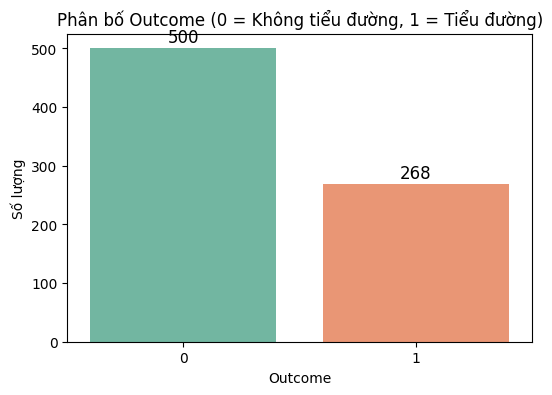

In [6]:
counts = df_dataset["Outcome"].value_counts().sort_index()

# Vẽ barchart
plt.figure(figsize=(6,4))
sns.barplot(x=counts.index, y=counts.values, palette="Set2")

# Thêm nhãn
plt.title("Phân bố Outcome (0 = Không tiểu đường, 1 = Tiểu đường)")
plt.xlabel("Outcome")
plt.ylabel("Số lượng")
for i, v in enumerate(counts.values):
    plt.text(i, v + 10, str(v), ha="center", fontsize=12)

plt.savefig("outcome.png")
plt.show()

**Nhận xét:**
  + Dữ liệu cần phân loại là người mắc bệnh **(1)** và người không mắc bệnh **(0)**
  +  Tỉ lệ chênh lệch giữa người không mắc bệnh/ người mắc bệnh là: **500/268**  

#### (5) **Mối tương quan giữa các tính chất (Correlations)**

Sự tương quan (correlation) đề cập đến mối quan hệ giữa hai biến và cách chúng có thể có hoặc không cùng nhau thay đổi.

Phương pháp phổ biến nhất để tính toán tương quan là Pearson's Correlation Coeficient, giả định có một phân phối chuẩn của các thuộc tính liên quan. Tương quan -1 hoặc 1 cho thấy mối tương quan âm hoặc dương đầy đủ tương ứng. Trong khi giá trị 0 hiển thị không tương quan ở tất cả.

$$
r = \frac{\sum_{i=1}^n{\left(x_i - \hat{x}\right)\left(y_i - \hat{y}\right)}}{\sqrt{\sum_{i=1}^n{\left(x_i - \hat{x}\right)^2}\sum_{i=1}^n{\left(y_i - \hat{y}\right)^2}}}
$$

Một số thuật toán học máy như hồi quy tuyến tính và logistic có hiệu suất kém nếu có các thuộc tính tương quan cao trong tập dữ liệu của bạn.

Như vậy, thật sự cần thiết để xem xét tất cả các mối tương quan theo cặp của các thuộc tính trong tập dữ liệu.

In [ ]:
corr = df_dataset.corr(method='pearson')
display(corr)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,Outcome
Pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
Glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
BloodPressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
SkinThickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
Insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
DPF,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
Age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
Outcome,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


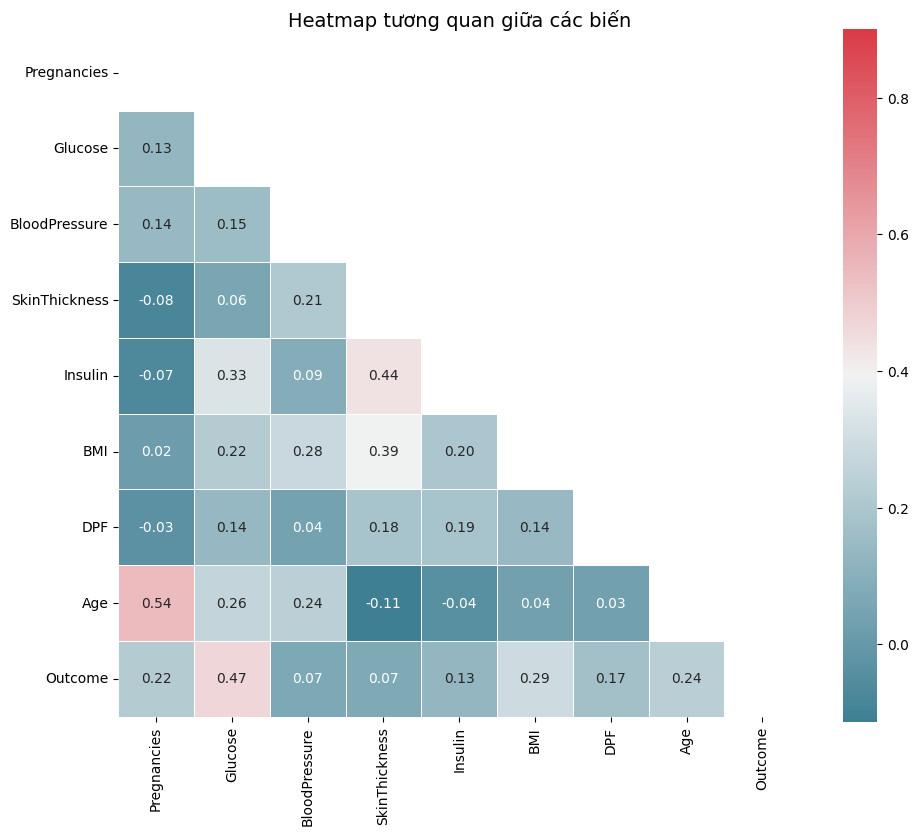

<Figure size 640x480 with 0 Axes>

In [ ]:
# Tạo mask cho tam giác trên (để không lặp lại giá trị)
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Tạo figure
f, ax = plt.subplots(figsize=(11, 9))

# Tạo colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Vẽ heatmap
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, square=True,
            linewidths=.5, annot=True, fmt=".2f", ax=ax)

plt.title("Heatmap tương quan giữa các biến", fontsize=14)
plt.show()
plt.savefig('heatmap.png')

**Nhận xét ma trận tương quan:**

  + **Glucose** (0.47) có tương quan mạnh nhất với Outcome → yếu tố dự báo chính.

  + **BMI** (0.29), **Age** (0.24), **Pregnancies** (0.22) cũng có liên hệ đáng kể → yếu tố nguy cơ quan trọng.

  + **DPF** (0.17), **Insulin** (0.13), **SkinThickness** (0.07), **BloodPressure** (0.06) tương quan yếu → chỉ mang tính bổ trợ.

+ Quan hệ giữa predictors: **Age–Pregnancies** (0.54), **SkinThickness–Insulin** (0.44), **SkinThickness–BMI** (0.39), **Glucose–Insulin** (0.33) → đều hợp lý về sinh học.

+ Không có đa cộng tuyến nghiêm trọng (tương quan giữa predictors < 0.8).

#### (6) **EDA mở rộng**

##### Thống kê mô tả phân tách theo Outcome

In [ ]:
stats_by_outcome = df_dataset.groupby("Outcome").agg(["mean", "median", "std"])
display(stats_by_outcome.T)

Outcome                        0           1
Pregnancies   mean      3.298000    4.865672
              median    2.000000    4.000000
              std       3.017185    3.741239
Glucose       mean    109.980000  141.257463
              median  107.000000  140.000000
              std      26.141200   31.939622
BloodPressure mean     68.184000   70.824627
              median   70.000000   74.000000
              std      18.063075   21.491812
SkinThickness mean     19.664000   22.164179
              median   21.000000   27.000000
              std      14.889947   17.679711
Insulin       mean     68.792000  100.335821
              median   39.000000    0.000000
              std      98.865289  138.689125
BMI           mean     30.304200   35.142537
              median   30.050000   34.250000
              std       7.689855    7.262967
DPF           mean      0.429734    0.550500
              median    0.336000    0.449000
              std       0.299085    0.372354
Age           mean     31.190000   37.067164
              median   27.000000   36.000000
              std      11.667655   10.968254

Bảng này cho thấy sự khác biệt trung bình (mean), trung vị (median), và độ lệch chuẩn (std) giữa nhóm tiểu đường và không tiểu đường.

**Nhận xét:**
+ Các biến Glucose, BMI, Age, Pregnancies, DPF có sự khác biệt rõ rệt giữa hai nhóm → nhiều khả năng là các predictor mạnh.

+ Insulin có dữ liệu chưa sạch (median = 0 ở nhóm tiểu đường) → cần cẩn trọng.

+ BloodPressure và SkinThickness ít khác biệt hơn, có thể ảnh hưởng nhưng không mạnh.

##### Violin plot / KDE plot

So sánh phân bố Glucose, BMI, Age, SkinThickness, Insulin giữa nhóm tiểu đường và không tiểu đường.

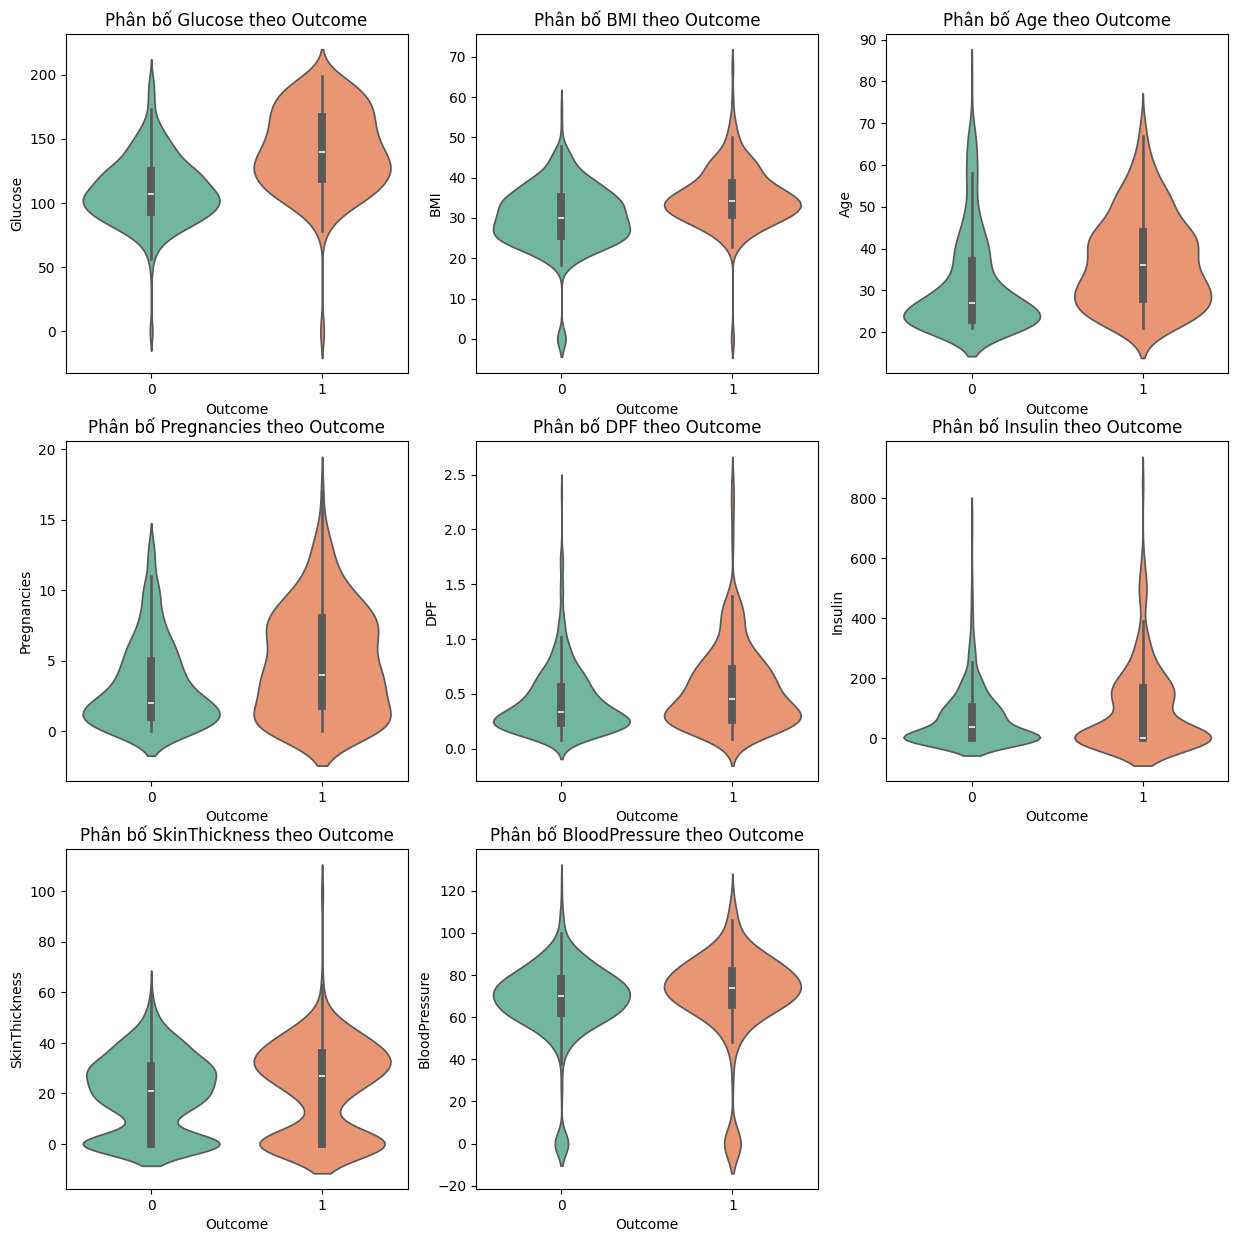

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(15, 15))
for i, col in enumerate(["Glucose", "BMI", "Age", "Pregnancies", "DPF", "Insulin","SkinThickness", "BloodPressure"], 1):
    plt.subplot(3, 3, i)
    sns.violinplot(x="Outcome", y=col, data=df_dataset,  hue="Outcome", palette="Set2", legend=False )
    plt.title(f"Phân bố {col} theo Outcome")
plt.show()
plt.savefig('violin.png')

**Nhận xét:**
+ Glucose là đặc trưng mạnh nhất để phân biệt hai nhóm.

+ BMI, Age, Pregnancies cũng thể hiện sự khác biệt, đóng vai trò là yếu tố nguy cơ bổ sung.
+ DPF ít có sự khác biệt giữa hai nhóm.
+ Kết quả này phù hợp với hiểu biết lâm sàng từ các paper (WHO 1999, Pima dataset).

### 3.2. Hiển thị dữ liệu (Visualize Data)

#### (1) Hiển thị trên từng tính chất đơn (Univariate Plots)
**Box and whisker plots**

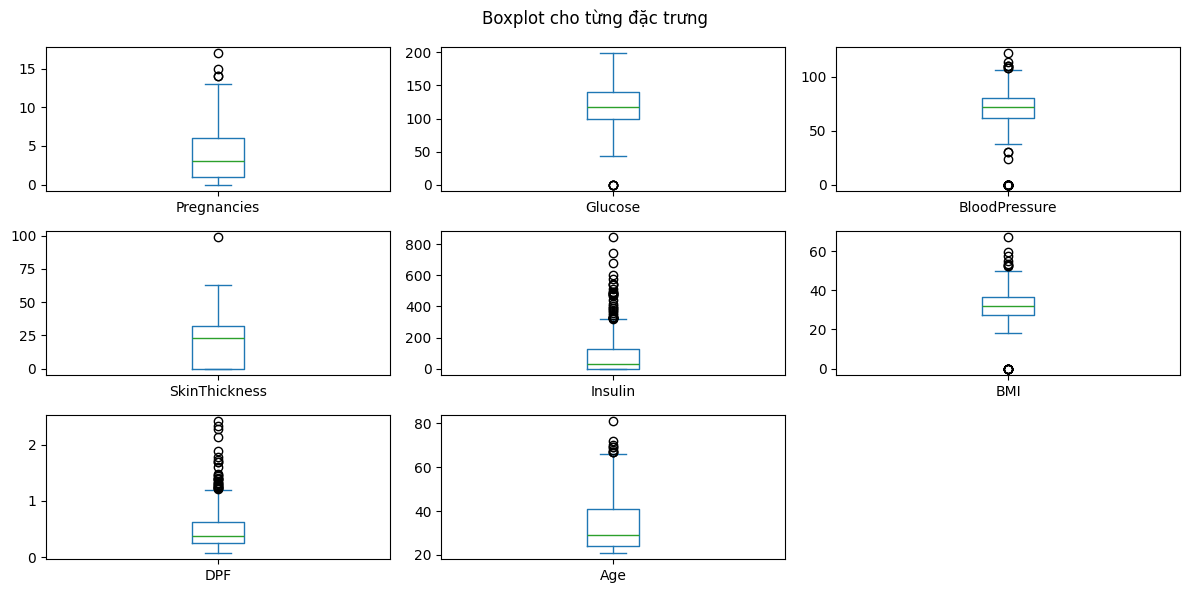

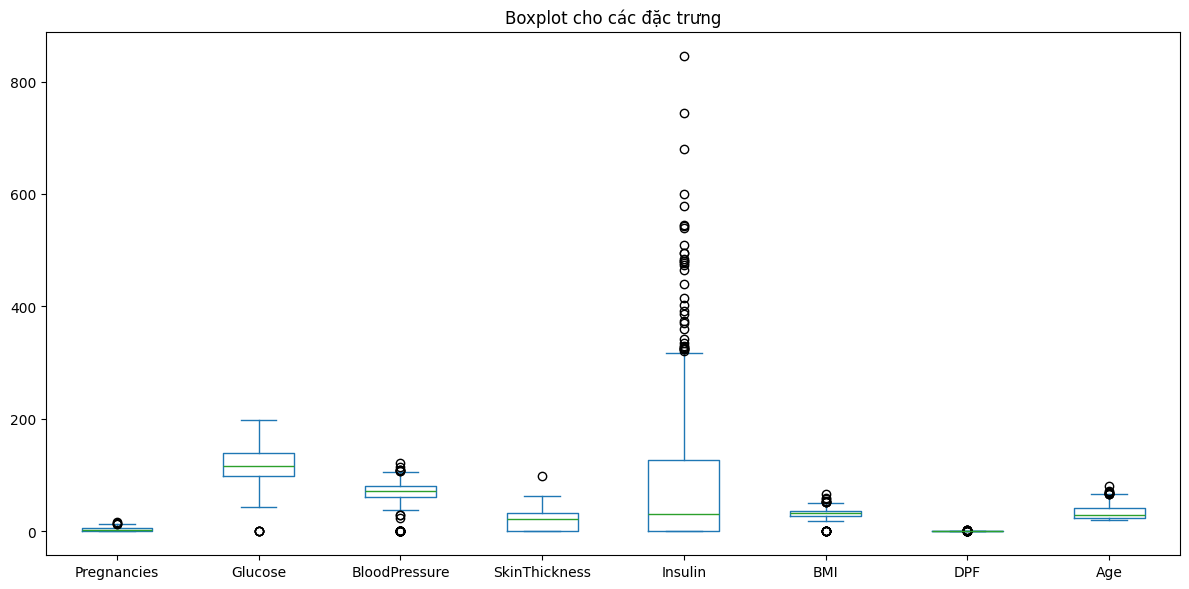

In [ ]:
cols = df_dataset.columns[:-1]
df_dataset[cols].plot(kind="box", subplots=True, layout=(3, 3),
                      sharex=False, sharey=False, figsize=(12,6))
plt.suptitle("Boxplot cho từng đặc trưng")
plt.tight_layout()
plt.savefig("boxplot_subplots.png", dpi=300)   # Lưu hình
plt.show()

df_dataset[cols].plot(kind="box", figsize=(12,6))
plt.title("Boxplot cho các đặc trưng")
plt.tight_layout()
plt.savefig("boxplot_all.png", dpi=300)
plt.show()

**Biểu đồ Histogram**

  Chúng ta có thể quan sát kỹ hơn mối quan hệ giữa Outcome và các biến dự đoán bằng cách sử dụng biểu đồ histogram như dưới đây. Ở mỗi biểu đồ, phần thứ nhất biểu diễn nhóm Outcome = 0 (không mắc tiểu đường), còn phần thứ hai biểu diễn nhóm Outcome = 1 (mắc tiểu đường).

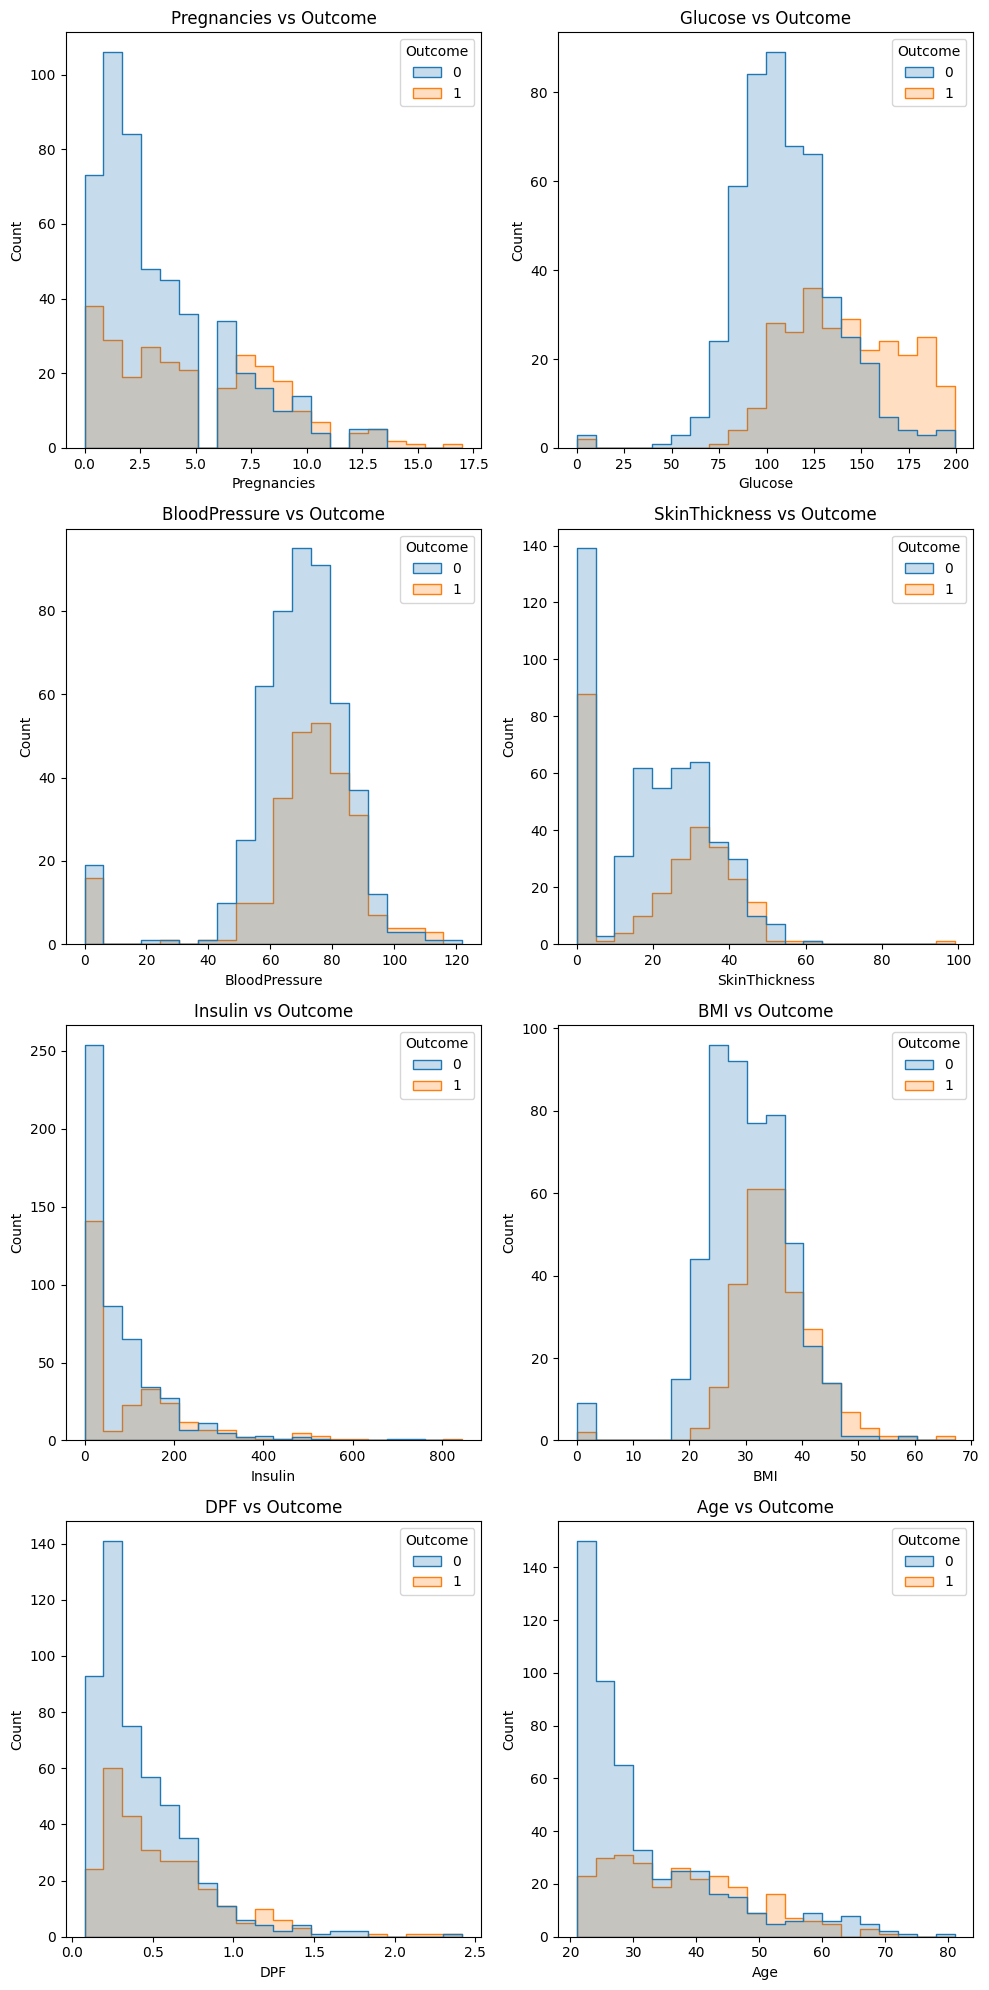

In [ ]:
plt.figure(figsize=(10, 20))

for i, col in enumerate(cols, 1):
    plt.subplot(4, 2, i)
    sns.histplot(data=df_dataset, x=col, hue="Outcome", bins=20, kde=False, element="step")
    plt.title(f"{col} vs Outcome")

plt.tight_layout()
plt.savefig("histogram_subplots.png", dpi=300)
plt.show()

**Nhận xét:**
+ Số lần mang thai trung bình ở nhóm Outcome = 1 (mắc tiểu đường) dường như cao hơn.
+ Những người mắc tiểu đường thường có chỉ số **glucose** cao hơn, trong khi những người bình thường thì **glucose** trong khoảng **90-100**.
+ Xu hướng của **BloodPressure** trông giống nhau ở cả nhóm mắc tiểu đường và không mắc tiểu đường.
+ **SkinThickness** trung bình của những người mắc tiểu đường có vẻ cao hơn một chút so với những người không mắc tiểu đường.
+ Mức **insulin** gần như giống nhau, chỉ khác là khoảng giá trị **insulin** của nhóm không mắc tiểu đường hẹp hơn.
+ Chỉ số **BMI** tương tự với SkinThickness.
+ Giá trị max và average của **DFF** của nhóm Outcome = 1 cao hơn.
+ Nhóm người không mắc bệnh nằm trong độ tuổi **20**, còn những người mắc bệnh thì trải đều **20-40** và cũng có nhiều trường hợp **>50**.

#### (2) Hiển thị nhiều tính chất (Multivariate Plots)

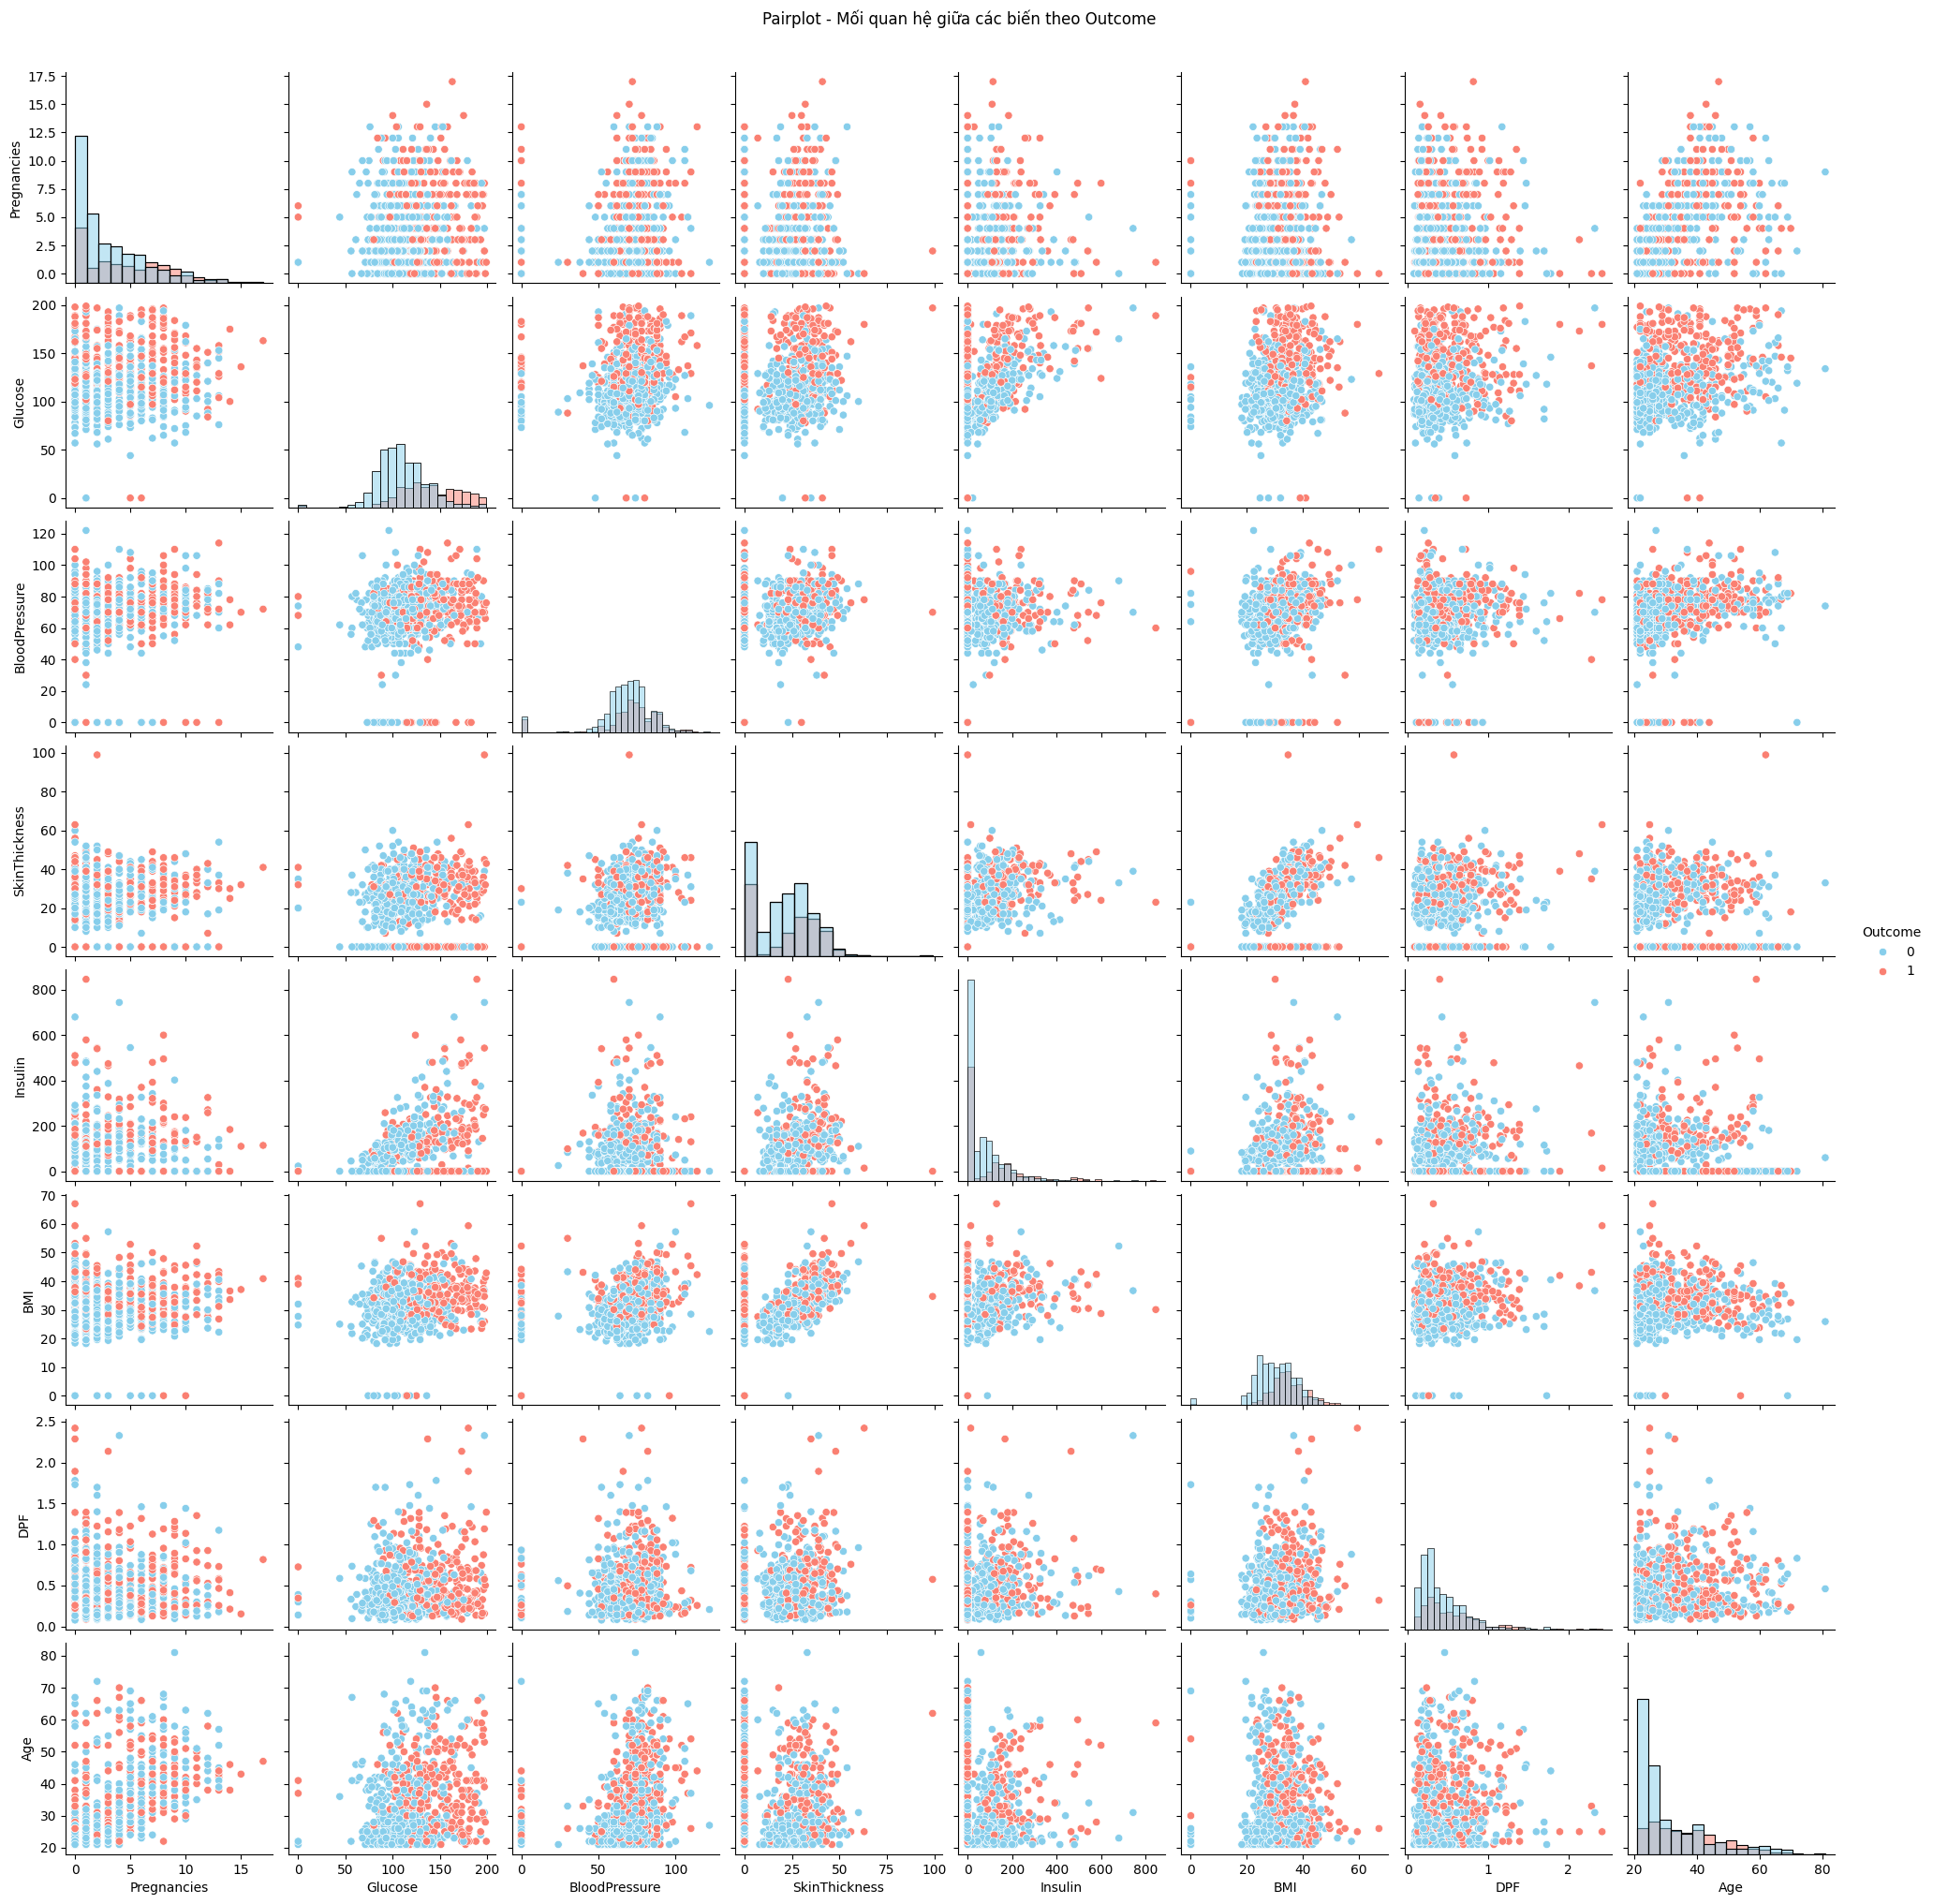

In [ ]:
numeric_df = df_dataset.select_dtypes(include=["int64", "float64"])

# Pairplot với Outcome làm hue
sns.pairplot(numeric_df, hue="Outcome", diag_kind="hist", palette={0: "skyblue", 1: "salmon"})
plt.suptitle("Pairplot - Mối quan hệ giữa các biến theo Outcome", y=1.02)
plt.savefig("pairplot.png")
plt.show()

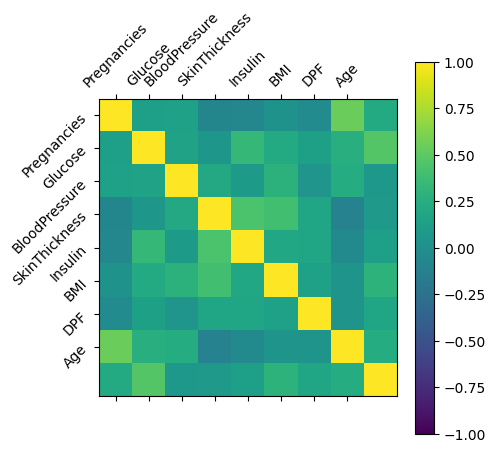

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.matshow(corr, vmin=-1, vmax=1)
plt.colorbar()
plt.xticks(np.arange(len(df_dataset.columns[:-1])), rotation=45)
plt.yticks(np.arange(len(df_dataset.columns[:-1])), rotation=45)
plt.gca().set_xticklabels(list(df_dataset.columns[:-1]))
plt.gca().set_yticklabels(list(df_dataset.columns[:-1]))
plt.show()
plt.savefig('matrix_corr.png')


## 4. Chuẩn bị dữ liệu (Prepare Data)

### 4.1. Làm sạch dữ liệu (Data Cleaning)

#### (1) **Tạo bảng dữ liệu làm sạch**


In [ ]:
df_rem = df_dataset.copy()

#### (2) **Xử lý giá trị rỗng, không hợp lệ**
Như đã nêu ở trên, chúng ta có thể loại bỏ các hàng có giá trị bằng 0 trong các cột **Glucose, BloodPressure và BMI**.

In [ ]:
### Tạo DataFrame mới, loại bỏ các hàng không mong muốn
df_rem = df_dataset[(df_dataset["Glucose"] != 0) & (df_dataset["BloodPressure"] != 0) & (df_dataset["BMI"] != 0)]

### Kiểm tra DataFrame mới
print("Size of dataframe:", df_rem.shape)
df_rem.head()


Size of dataframe: (724, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
### Kiểm tra giá trị nhỏ nhất trong df_rem
df_rem.describe().loc["min"]

,min
Pregnancies,0.000
Glucose,44.000
BloodPressure,24.000
SkinThickness,0.000
Insulin,0.000
BMI,18.200
DPF,0.078
Age,21.000
Outcome,0.000


+ Có 44 dòng có giá trị 0 ở cột Glucose, BloodPressure và BMI được loại bỏ.

**Impute (Điền giá trị thay thế)**

Vì có nhiều hàng dữ liệu với giá trị bằng 0 ở cột **SkinThickness** và **Insulin**, chúng ta sẽ sử dụng Hồi quy tuyến tính (**Linear Regression**) để ước lượng và thay thế những giá trị này thành các giá trị khác không bằng 0.

In [ ]:
# 1. Tách dữ liệu hợp lệ (có giá trị khác 0)
df_valid = df_rem[(df_rem["SkinThickness"] != 0) & (df_rem["Insulin"] != 0)].copy()
df_missing = df_rem[(df_rem["SkinThickness"] == 0) | (df_rem["Insulin"] == 0)].copy()

# 2. Impute cho SkinThickness
linreg_skin = LinearRegression()
linreg_skin.fit(
    df_valid.drop(["SkinThickness", "Outcome"], axis=1),
    df_valid["SkinThickness"]
)

# Dự đoán SkinThickness cho các hàng thiếu
mask_skin = df_missing["SkinThickness"] == 0
df_missing.loc[mask_skin, "SkinThickness"] = linreg_skin.predict(
    df_missing.loc[mask_skin].drop(["SkinThickness", "Outcome"], axis=1)
)

# 3. Impute cho Insulin
linreg_ins = LinearRegression()
linreg_ins.fit(
    df_valid.drop(["Insulin", "Outcome"], axis=1),
    df_valid["Insulin"]
)

# Dự đoán Insulin cho các hàng thiếu
mask_ins = df_missing["Insulin"] == 0
df_missing.loc[mask_ins, "Insulin"] = linreg_ins.predict(
    df_missing.loc[mask_ins].drop(["Insulin", "Outcome"], axis=1)
)

# 4. Gộp dữ liệu đã xử lý lại
df_impute = pd.concat([df_valid, df_missing], axis=0)

# 5. Thống kê kết quả
display(df_impute.describe())



/tmp/ipython-input-3635307585.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[21.3283968  21.6394621  33.02751222 35.8049769  28.06245287 25.97443981
 33.37968618 37.61326484 36.75258344 30.68985638 15.86343349 30.9819479
 37.57458947 25.02254749 25.64547126 38.84547248 30.2168814  21.55620221
 30.02427955 40.44218026 41.91560197 29.50940795 44.86816717 13.75306074
 22.29611099 36.05423086 21.06580117 17.12936706 35.33689975 17.30239736
 29.2428709  29.99626533 30.52426167 29.56609911 25.92395732 27.77633267
 26.14372811 31.50615171 26.93260822 19.02575956 30.14581056 32.4956005
 18.74928509 45.34092695 27.6075308  26.45088045 27.88087613 27.18351386
 28.21172109 42.0201168  36.50725834 19.2265115  22.37426621 24.44064749
 17.57010808 27.75521569 18.8957559  35.0776409  35.32756757 34.44243559
 30.90238931 30.13466076 39.55992463 30.87301363 39.50233567 13.96241323
 21.18494879 28.98370954 28.97825

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,Outcome
count,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000
mean,3.866022,121.882597,72.400552,28.903743,152.616866,32.467127,0.474765,33.350829,0.343923
std,3.362803,30.750030,12.379870,9.699674,99.676938,6.888941,0.332315,11.765393,0.475344
min,0.000000,44.000000,24.000000,7.000000,-20.230088,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,22.000000,88.000000,27.500000,0.245000,24.000000,0.000000
50%,3.000000,117.000000,72.000000,28.440016,130.000000,32.400000,0.379000,29.000000,0.000000
75%,6.000000,142.000000,80.000000,35.000000,190.000000,36.600000,0.627500,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### 4.2. Biến đổi dữ liệu (Data Transforms)

#### (1) Chuẩn hóa dữ liệu (Standard Scaler)

In [ ]:
scale_columns = ["Pregnancies", "Glucose","BloodPressure","SkinThickness", "Insulin", "BMI", "DPF", "Age"]
#Khởi tạo Standard Scaler
scaler = StandardScaler()

#Fit scaler với tập huấn luyện
scaler.fit(df_impute[scale_columns])

df_impute[scale_columns] = scaler.transform(df_impute[scale_columns])

df_impute



,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,Outcome
3,-0.852861,-1.070091,-0.517370,-0.609075,-0.588475,-0.634371,-0.926765,-1.050485,0
4,-1.150438,0.491962,-2.619006,0.628936,0.154437,1.544537,5.460146,-0.029839,1
6,-0.257708,-1.428061,-1.810684,0.319433,-0.648711,-0.213116,-0.682852,-0.625216,1
8,-0.555284,2.444529,-0.194042,1.660611,3.919192,-0.285746,-0.953867,1.671237,1
13,-0.852861,2.184187,-1.002363,-0.609075,6.961114,-0.343850,-0.231161,2.181559,1
...,...,...,...,...,...,...,...,...,...
761,1.527752,1.565874,0.129287,0.216266,1.202336,1.675271,-0.216105,0.820699,1
762,1.527752,-1.070091,-0.840699,-0.989967,-1.013002,-1.447830,-1.002047,-0.029839,0
764,-0.555284,0.003821,-0.194042,-0.196404,0.078326,0.629395,-0.405815,-0.540162,0
766,-0.852861,0.133992,-1.002363,-0.201194,0.310482,-0.343850,-0.378713,1.160914,1


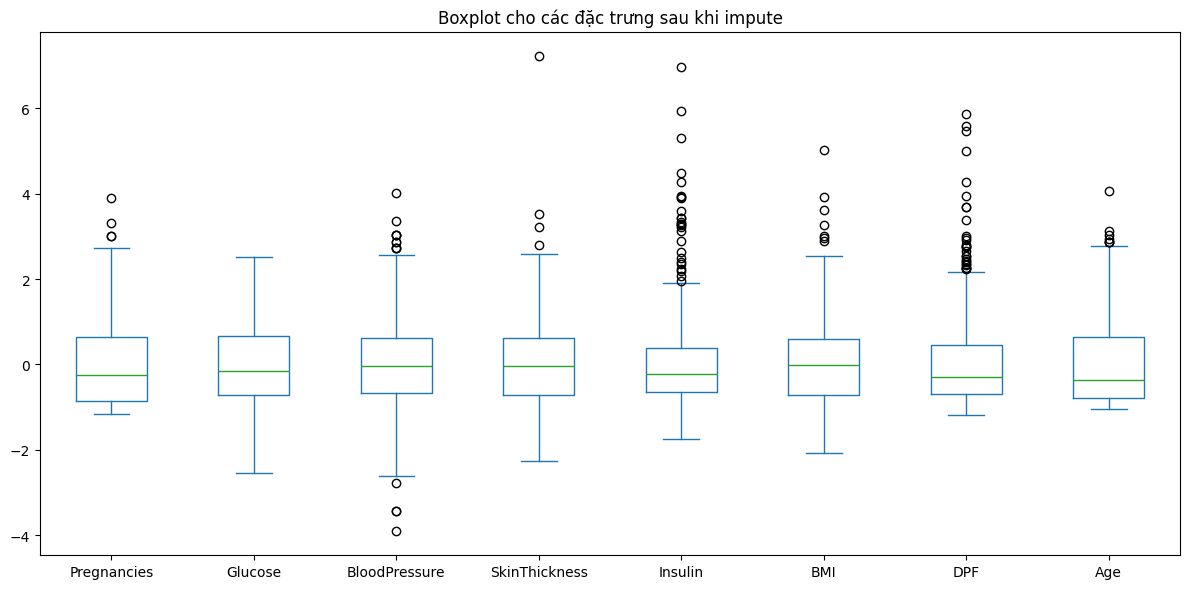

In [ ]:
df_impute[scale_columns].plot(kind="box", figsize=(12,6));
plt.title("Boxplot cho các đặc trưng sau khi impute")
plt.tight_layout()
plt.savefig("boxplot_all_after_impute.png", dpi=300)
plt.show()

In [ ]:
correlations = df_impute.corr(method='pearson')
display(correlations)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,Outcome
Pregnancies,1.000000,0.134915,0.209668,0.107733,0.049028,0.012342,-0.025996,0.557066,0.224417
Glucose,0.134915,1.000000,0.223331,0.226076,0.691548,0.223276,0.136630,0.263560,0.488384
BloodPressure,0.209668,0.223331,1.000000,0.235181,0.130822,0.287403,-0.000075,0.324897,0.166703
SkinThickness,0.107733,0.226076,0.235181,1.000000,0.234985,0.700943,0.132549,0.141561,0.266147
Insulin,0.049028,0.691548,0.130822,0.234985,1.000000,0.268929,0.153038,0.218317,0.350641
BMI,0.012342,0.223276,0.287403,0.700943,0.268929,1.000000,0.154858,0.020835,0.299375
DPF,-0.025996,0.136630,-0.000075,0.132549,0.153038,0.154858,1.000000,0.023098,0.184947
Age,0.557066,0.263560,0.324897,0.141561,0.218317,0.020835,0.023098,1.000000,0.245741
Outcome,0.224417,0.488384,0.166703,0.266147,0.350641,0.299375,0.184947,0.245741,1.000000


#### (2) Chia dữ liệu thực nghiệm
+ Chuyển đổi dữ liệu sang dạng numpy với phần Input (X_data), Output (y_data)
+ Chia dữ liệu thành tập train/test (tỷ lệ 70/30)
+ Lưu tất cả thông tin để chuẩn bị chạy thuật toán

In [ ]:
### Tách biến dự đoán (predictors) và biến mục tiêu (target)
X = df_impute.drop(["Outcome"], axis=1)
y = df_impute["Outcome"]

print("Size of x (predictors):\t{}\nSize of y (target):\t{}".format(X.shape, y.shape))
display(X[:20])
display(y[:20])

Size of x (predictors):	(724, 8)
Size of y (target):	(724,)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age
3,-0.852861,-1.070091,-0.517370,-0.609075,-0.588475,-0.634371,-0.926765,-1.050485
4,-1.150438,0.491962,-2.619006,0.628936,0.154437,1.544537,5.460146,-0.029839
6,-0.257708,-1.428061,-1.810684,0.319433,-0.648711,-0.213116,-0.682852,-0.625216
8,-0.555284,2.444529,-0.194042,1.660611,3.919192,-0.285746,-0.953867,1.671237
13,-0.852861,2.184187,-1.002363,-0.609075,6.961114,-0.343850,-0.231161,2.181559
14,0.337445,1.435703,-0.032378,-1.021745,0.224712,-0.968471,0.337970,1.501129
16,-1.150438,-0.126350,0.937608,1.866946,0.776876,1.936740,0.229564,-0.199947
18,-0.852861,-0.614492,-3.427327,0.938438,-0.698908,1.573589,-0.878585,-0.029839
19,-0.852861,-0.223979,-0.194042,0.113098,-0.568396,0.309822,0.163316,-0.114893
20,-0.257708,0.133992,1.260937,1.247941,0.827073,0.992547,0.690289,-0.540162


,Outcome
3,0
4,1
6,1
8,1
13,1
14,1
16,1
18,0
19,1
20,0


In [ ]:
# Chia tập dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=1
)
# Kiểm tra kích thước để chắc chắn mọi thứ đúng
print("Kích thước X_train: {} \t Kích thước X_test: {} \nKích thước y_train: {} \t Kích thước y_test: {}".format(
    X_train.shape, X_test.shape, y_train.shape, y_test.shape))
print(f'+ Train/Test: Train Ratio = {len(X_train)/len(X)}')
print(f'+ Train: shape={X_train.shape}')
print('Input = \n')
display(X_train[:5])
print('Output = \n')
display(y_train[:5])
print(f'+ Test: shape={X_test.shape}')
print('Input = \n')
display(y_test[:5])
print('Output = \n')
display(y_test[:5])

Kích thước X_train: (506, 8) 	 Kích thước X_test: (218, 8) 
Kích thước y_train: (506,) 	 Kích thước y_test: (218,)
+ Train/Test: Train Ratio = 0.6988950276243094
+ Train: shape=(506, 8)
Input = 



,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age
497,-0.555284,-1.330433,-0.032378,-1.434415,-0.769183,-0.343850,0.217519,-0.710270
191,1.527752,0.036363,-0.194042,1.557443,-0.588475,0.091931,-0.303432,0.565537
374,-0.555284,0.003821,-1.649020,1.454276,0.054043,0.542239,1.027551,-0.455108
626,-1.150438,0.101449,-0.355706,-0.994642,-0.111261,-1.128257,-0.809325,-1.050485
149,-0.555284,-1.037548,-0.194042,-1.228080,-0.869618,-0.750580,-1.173690,-0.965431


Output = 



,Outcome
497,0
191,0
374,0
626,0
149,0


+ Test: shape=(218, 8)
Input = 



,Outcome
144,0
175,1
488,0
612,1
675,1


Output = 



,Outcome
144,0
175,1
488,0
612,1
675,1


In [ ]:
# Lưu thông tin
save_dir = "exps/pima-indians"
if os.path.exists(save_dir) == False: os.makedirs(save_dir)

# Save training data
np.savez(f'{save_dir}/data.npz', X_train=X_train, X_test=X_test, y_train=y_test, y_test=y_test)
# Save cleaning data
df_impute.to_excel(f'{save_dir}/df_impute.xlsx', index=False)
# Save encoders - Removed as class_encoder is not defined
# joblib.dump(class_encoder, f'{save_dir}/class_encoder.joblib')

os.listdir(save_dir)

['data.npz', 'df_impute.xlsx']

In [ ]:
# Kiểm tra phục hồi dữ liệu
dict(np.load(f'{save_dir}/data.npz')).keys()

dict_keys(['X_train', 'X_test', 'y_train', 'y_test'])

In [ ]:
pd.read_excel(f'{save_dir}/df_impute.xlsx')

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,Outcome
0,-0.852861,-1.070091,-0.517370,-0.609075,-0.588475,-0.634371,-0.926765,-1.050485,0
1,-1.150438,0.491962,-2.619006,0.628936,0.154437,1.544537,5.460146,-0.029839,1
2,-0.257708,-1.428061,-1.810684,0.319433,-0.648711,-0.213116,-0.682852,-0.625216,1
3,-0.555284,2.444529,-0.194042,1.660611,3.919192,-0.285746,-0.953867,1.671237,1
4,-0.852861,2.184187,-1.002363,-0.609075,6.961114,-0.343850,-0.231161,2.181559,1
...,...,...,...,...,...,...,...,...,...
719,1.527752,1.565874,0.129287,0.216266,1.202336,1.675271,-0.216105,0.820699,1
720,1.527752,-1.070091,-0.840699,-0.989967,-1.013002,-1.447830,-1.002047,-0.029839,0
721,-0.555284,0.003821,-0.194042,-0.196404,0.078326,0.629395,-0.405815,-0.540162,0
722,-0.852861,0.133992,-1.002363,-0.201194,0.310482,-0.343850,-0.378713,1.160914,1


# **Kết thúc**